## Demonstration of Spoken Digits Classification

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the classification of recorded spoken digits in the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) (FSDD). Please download/clone the dataset before executing this notebook. Mel-Frequency Cepstral Coefficients (MFCCs) are used as two-dimensional features which are fed into a convolutive neural network (CNN) for classification.

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from librosa.feature import mfcc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Activation, Flatten, MaxPooling2D, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = '../data/free-spoken-digit-dataset/recordings/'  # path to dataset

### Load Dataset

The FSDD consists of a series of wav files containing recordings of the single spoken digits `0-9` for different individuals. Each digit has been recorded multiple times for each individual. In the following, all samples in the database are loaded, normalized and truncated to a common length.

In [3]:
def load_examples(path):

    X = list()
    Y = list()

    audiofiles = glob.glob(path, recursive=True)
    for filepath in audiofiles:
        x, fs = sf.read(filepath)
        x = x / np.max(np.abs(x))
        X.append(x)
        Y.append(int(os.path.basename(filepath)[0]))

    return X, Y, fs


# load examples
X_raw, Y, fs = load_examples(path + '*.wav')

# determine maximum length of the examples
lengths = [len(x) for x in X_raw]
F = np.max(lengths)

# append zeros to examples to equalize lengths
X_raw = [np.concatenate((sample, np.zeros(F - len(sample))))
         for sample in X_raw]
X_raw = np.array(X_raw)
Y = np.array(Y)

# one-hot encoding of class labels
Y1h = to_categorical(Y, 10)

In [4]:
print('Total number of examples: {}'.format(len(X_raw)))
print('Number of samples per example: {}'.format(F))

Total number of examples: 3000
Number of samples per example: 18262


### Feature Extraction

Now the MFCCs for each example are computed.

In [5]:
X = [mfcc(y=sample, sr=fs, htk=True) for sample in X_raw]
X = np.array(X)

print('Total number of examples: {}'.format(X.shape[0]))
print('Dimension of feature vectors: {}'.format(X.shape[1:]))

Total number of examples: 3000
Dimension of feature vectors: (20, 36)


### Define and Train the Model

The model is defined as a concatenation of an input layer, two-dimensional convolutional layers, activation layers, pooling layers and an output layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized.

In [6]:
def rnn_model(input_shape=(20,36), classes=10):

    inputs = Input(shape=input_shape)

    z = LSTM(100, dropout=0.5)(inputs)
    z = Dense(classes, activation='softmax')(z)

    return Model(inputs, z)


model = rnn_model()
model.summary()

2022-01-27 20:32:03.331330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 36)]          0         
                                                                 
 lstm (LSTM)                 (None, 100)               54800     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 55,810
Trainable params: 55,810
Non-trainable params: 0
_________________________________________________________________


Now the model is compiled and trained. We used the `categorical crossentropy` as loss and the `Adam` optimizer. As evaluation metrics, the accuracy of the prediction is used. The examples are split into a set of examples used for training and a set used for validation of the trained model. The loss and the accuracy is plotted for each epoch for both the training and validation subsets. Early stopping is used to prevent overfitting of the model.

In [7]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1h, test_size=0.2)

callback = EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), epochs=200, batch_size=64)

Epoch 1/200
38/38 [==============================] - 2s 20ms/step - loss: 2.3061 - accuracy: 0.1342 - val_loss: 2.2354 - val_accuracy: 0.1933
Epoch 2/200
38/38 [==============================] - 0s 11ms/step - loss: 2.1852 - accuracy: 0.2017 - val_loss: 2.1480 - val_accuracy: 0.2250
Epoch 3/200
38/38 [==============================] - 0s 11ms/step - loss: 2.1230 - accuracy: 0.2521 - val_loss: 2.0836 - val_accuracy: 0.2633
Epoch 4/200
38/38 [==============================] - 0s 11ms/step - loss: 2.0599 - accuracy: 0.2750 - val_loss: 2.0318 - val_accuracy: 0.2717
Epoch 5/200
38/38 [==============================] - 0s 11ms/step - loss: 1.9928 - accuracy: 0.3092 - val_loss: 1.9731 - val_accuracy: 0.2933
Epoch 6/200
38/38 [==============================] - 0s 11ms/step - loss: 1.9500 - accuracy: 0.3225 - val_loss: 1.8906 - val_accuracy: 0.3467
Epoch 7/200
38/38 [==============================] - 0s 12ms/step - loss: 1.8787 - accuracy: 0.3296 - val_loss: 1.8312 - val_accuracy: 0.3533
Epoch 

38/38 [==============================] - 0s 12ms/step - loss: 0.6884 - accuracy: 0.7729 - val_loss: 0.6374 - val_accuracy: 0.8100
Epoch 59/200
38/38 [==============================] - 0s 12ms/step - loss: 0.6788 - accuracy: 0.7667 - val_loss: 0.6271 - val_accuracy: 0.8167
Epoch 60/200
38/38 [==============================] - 0s 12ms/step - loss: 0.6167 - accuracy: 0.7954 - val_loss: 0.6253 - val_accuracy: 0.8083
Epoch 61/200
38/38 [==============================] - 0s 12ms/step - loss: 0.6314 - accuracy: 0.7867 - val_loss: 0.6142 - val_accuracy: 0.8100
Epoch 62/200
38/38 [==============================] - 0s 11ms/step - loss: 0.6003 - accuracy: 0.8029 - val_loss: 0.6309 - val_accuracy: 0.8133
Epoch 63/200
38/38 [==============================] - 0s 11ms/step - loss: 0.6243 - accuracy: 0.7875 - val_loss: 0.5832 - val_accuracy: 0.8317
Epoch 64/200
38/38 [==============================] - 0s 11ms/step - loss: 0.5656 - accuracy: 0.8075 - val_loss: 0.6072 - val_accuracy: 0.8100
Epoch 65/200

38/38 [==============================] - 0s 12ms/step - loss: 0.3709 - accuracy: 0.8767 - val_loss: 0.4729 - val_accuracy: 0.8683
Epoch 116/200
38/38 [==============================] - 0s 12ms/step - loss: 0.3981 - accuracy: 0.8750 - val_loss: 0.4985 - val_accuracy: 0.8633
Epoch 117/200
38/38 [==============================] - 1s 14ms/step - loss: 0.4011 - accuracy: 0.8575 - val_loss: 0.4819 - val_accuracy: 0.8667
Epoch 118/200
38/38 [==============================] - 0s 12ms/step - loss: 0.3692 - accuracy: 0.8746 - val_loss: 0.4690 - val_accuracy: 0.8650
Epoch 119/200
38/38 [==============================] - 0s 12ms/step - loss: 0.3343 - accuracy: 0.8846 - val_loss: 0.4812 - val_accuracy: 0.8633
Epoch 120/200
38/38 [==============================] - 1s 14ms/step - loss: 0.3723 - accuracy: 0.8771 - val_loss: 0.5057 - val_accuracy: 0.8517
Epoch 121/200
38/38 [==============================] - 1s 13ms/step - loss: 0.3863 - accuracy: 0.8654 - val_loss: 0.4799 - val_accuracy: 0.8600
Epoch 

Epoch 172/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2780 - accuracy: 0.9050 - val_loss: 0.4773 - val_accuracy: 0.8700
Epoch 173/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2831 - accuracy: 0.9025 - val_loss: 0.4422 - val_accuracy: 0.8783
Epoch 174/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2807 - accuracy: 0.9054 - val_loss: 0.4354 - val_accuracy: 0.8917
Epoch 175/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2808 - accuracy: 0.9013 - val_loss: 0.4542 - val_accuracy: 0.8883
Epoch 176/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2996 - accuracy: 0.8971 - val_loss: 0.4625 - val_accuracy: 0.8767
Epoch 177/200
38/38 [==============================] - 1s 14ms/step - loss: 0.2879 - accuracy: 0.9013 - val_loss: 0.4460 - val_accuracy: 0.8833
Epoch 178/200
38/38 [==============================] - 0s 13ms/step - loss: 0.2731 - accuracy: 0.9154 - val_loss: 0.4404 - val_accuracy:

### Evaluation of the Model

First we take a look at the evolution of the loss and the accuracy over the epochs

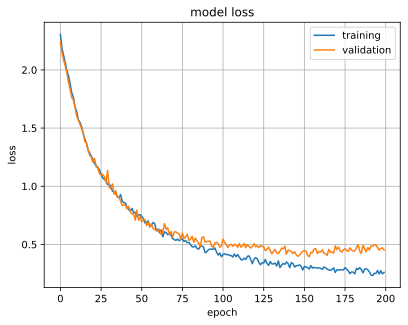

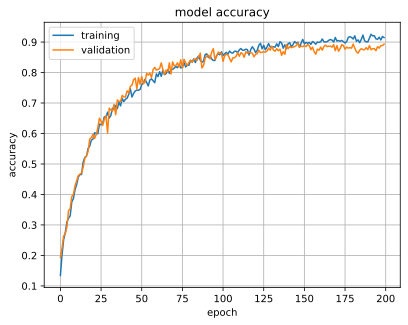

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')
plot_history(history, 'accuracy')

The performance of the trained classifier on the validation examples is summarized in the classification report including various performance metrics

In [9]:
Y_pred = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        58
           1       0.95      0.80      0.87        70
           2       0.74      0.90      0.81        39
           3       0.89      0.92      0.90        62
           4       0.97      0.97      0.97        71
           5       0.84      0.95      0.89        61
           6       0.94      0.93      0.94        55
           7       0.89      0.86      0.87        69
           8       0.91      0.90      0.91        59
           9       0.79      0.82      0.81        56

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.